In [1]:
import random
import numpy as np
import pandas as pd

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import WeibullAFTFitter
from lifelines.statistics import proportional_hazard_test
from functions import wb_AFT_reg, evaluate_survivals, conf_matrix,conf_matrix_metrics

from reliability.Fitters import Fit_Weibull_2P
from reliability.Other_functions import histogram
from reliability.Probability_plotting import plot_points
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('.\data.xlsx')
data = df[df.SISTEMA =='Vvolts'] 
cols_to_drop = ['FALLA','FECHA','REP','CAEX','SISTEMA']
data_to_eval = data.drop(cols_to_drop,axis=1).reset_index(drop=True)

### Ejemplo de como se ajustan los tiempos entre fallas de algunos camiones vs la función de supervivencia obtenida a partir del ajuste de una distribución Weibull

Fit_Weibull_2P parameters:
Alpha: 1508.4921667793371 
Beta: 0.6227763624851476


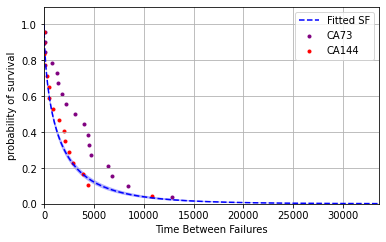

In [3]:
wbf = Fit_Weibull_2P(failures=list(data.TBF), show_probability_plot=False, print_results=False)
print('Fit_Weibull_2P parameters:\nAlpha:', wbf.alpha, '\nBeta:', wbf.beta) 

ca73 = data[data.CAEX=='CA73']
ca144 = data[data.CAEX=='CA144']
 
wbf.distribution.SF(label='Fitted SF',color='blue',linestyle='--')
plot_points(failures=list(ca73.TBF),func='SF',label='CA73',color='purple')
plot_points(failures=list(ca144.TBF),func='SF',label='CA144',color='red')

plt.title('')
plt.xlabel('Time Between Failures')
plt.ylabel('probability of survival')
plt.legend()
plt.grid('on')
plt.show()

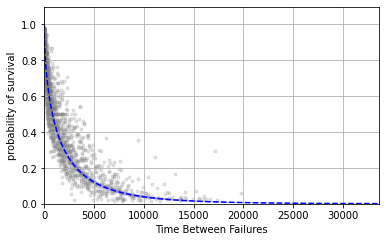

In [4]:
wbf.distribution.SF(label='Fitted SF',color='blue',linestyle='--')

for c in data.CAEX.unique():
    plot_points(failures=list(data[data.CAEX==c].TBF),func='SF',color='grey',alpha=0.2)

plt.title('')
plt.xlabel('Time Between Failures')
plt.ylabel('probability of survival')
plt.legend('',frameon=False)
plt.grid('on')
plt.show()

### Se selecciona al azar un registro por cada camión. 

#### El resultado a utilizar como referencia es: 

$\bullet$ 40 camiones que no lograron superar las 1000hrs antes de presentar una fallas 

$\bullet$  38 camiones cuyas fallas se presentaron pasadas las 500 hrs. 

In [4]:
np.random.seed(1234567890)
T = 1000
dfs = []
for caex in data.CAEX.unique():
    indxs = data[data['CAEX']==caex].index
    select_ind = random.choice(list(indxs))
    dfs.append(pd.DataFrame(data.loc[select_ind,:]).T)
dfs = pd.concat(dfs)
dfs['survive'] = [1 if x>T else 0 for x in dfs.TBF]

# CAEX  surviving 1000 hours and those that do not
#==================================================
CAEX_surv = dfs[dfs.survive==1].CAEX.to_list()
CAEX_notsurv = dfs[dfs.survive==0].CAEX.to_list()
caexs = dfs.reset_index(drop=True).CAEX
#==================================================

dfs.groupby('survive').agg({'CAEX':'count'})

,CAEX
survive,
0,40
1,38


### Se definen los modelos

In [3]:
residuals = []

# Lasso Weibull reg.
# =========================================================================================================================
w = WeibullAFTFitter(l1_ratio=1., penalizer=0.08).fit(data_to_eval, duration_col='TBF')
res = pd.DataFrame(w.params_).reset_index()
res_lambda = res[res.param=='lambda_'].rename(columns={0:'theta'})
res_lambda = res_lambda[res_lambda.theta>1e-10]
lasso_variables_wb = res_lambda.covariate.to_list()[:-1]
# =========================================================================================================================

# Proportional Hazard Test
# =========================================================================================================================
results = proportional_hazard_test(CoxPHFitter().fit(data_to_eval, duration_col='TBF'), data_to_eval, time_transform='km')
s = results.summary
# =========================================================================================================================

# Lasso Cox Model
# =========================================================================================================================
cx = CoxPHFitter(l1_ratio=1., penalizer=0.05453).fit(data_to_eval, duration_col='TBF')
res = pd.DataFrame(cx.params_).reset_index()
lasso_variables_cx = res[res.coef>1e-5].covariate.to_list()
# =========================================================================================================================

# Fitting the models A1-B5
# =========================================================================================================================
A1 = wb_AFT_reg(data=data[['TBF']],time_variable='TBF',residuals_list=residuals,ndecimals=3,print_results=False)
A2 = wb_AFT_reg(data=data_to_eval,time_variable='TBF',residuals_list=residuals,ndecimals=3,print_results=False)
A3 = wb_AFT_reg(data=data[['TBF']+lasso_variables_wb],time_variable='TBF',residuals_list=residuals,ndecimals=3,
                print_results=False)

B1 = CoxPHFitter().fit(data[['TBF']], duration_col='TBF')
B2 = CoxPHFitter().fit(data_to_eval, duration_col='TBF')
B3 = CoxPHFitter().fit(data[['TBF']+list(s[s.p<0.05].reset_index()['index'])], duration_col='TBF')
B4 = CoxPHFitter().fit(data_to_eval.drop(list(s[s.p<0.05].reset_index()['index']),axis=1), duration_col='TBF')
B5 = CoxPHFitter().fit(data[['TBF']+lasso_variables_cx], duration_col='TBF')
# =========================================================================================================================


Estimated scale parameter λ =  1508.483312449063
Estimated scale parameter λ =  1094.6769648854129
Estimated scale parameter λ =  1779.2794696697247


In [5]:
# Evaluating the models
# =========================================================================================================================
df_A2 = dfs[data_to_eval.columns].drop('TBF',axis=1).reset_index(drop=True)
df_A3 = dfs[lasso_variables_wb].reset_index(drop=True)
df_B3 = dfs[list(s[s.p<0.05].reset_index()['index'])]
df_B4 = dfs[data_to_eval.drop(list(s[s.p<0.05].reset_index()['index']),axis=1).columns.to_list()]
df_B5 = dfs[lasso_variables_cx]

A2_CAEX_surv, A2_CAEX_notsurv, probs_A2 = evaluate_survivals(T=T,thetas=A2[0], beta=A2[1], df=df_A2,
                                                             caex_list=caexs, model='weibull', fitted_model=A2)

A3_CAEX_surv, A3_CAEX_notsurv, probs_A3 = evaluate_survivals(T=T,thetas=A3[0], beta=A3[1], df=df_A3,
                                                    caex_list=caexs, model='weibull', fitted_model=A2)

B2_CAEX_surv, B2_CAEX_notsurv, probs_B2 = evaluate_survivals(T=T,thetas=pd.DataFrame(B2.params_).reset_index(),
                                                    beta=0, df=df_A2, caex_list=caexs, model='cox',fitted_model=B2)

B3_CAEX_surv, B3_CAEX_notsurv, probs_B3  =  evaluate_survivals(T=T,thetas=pd.DataFrame(B3.params_).reset_index(),
                                                    beta=0, df=df_B3, caex_list=caexs,model='cox', fitted_model=B3)

B4_CAEX_surv, B4_CAEX_notsurv, probs_B4 =  evaluate_survivals(T=T,thetas=pd.DataFrame(B4.params_).reset_index(),
                                                    beta=0, df=df_B4, caex_list=caexs,model='cox', fitted_model=B4)

B5_CAEX_surv, B5_CAEX_notsurv, probs_B5 = evaluate_survivals(T=T,thetas=pd.DataFrame(B5.params_).reset_index(),
                                                    beta=0, df=df_B5, caex_list=caexs,model='cox', fitted_model=B5)
# =========================================================================================================================

Estimated scale parameter λ =  1508.483312449063
Estimated scale parameter λ =  1094.6769648854129
Estimated scale parameter λ =  1779.2794696697247


In [6]:
print(len(A2_CAEX_surv),len(A3_CAEX_surv),len(B2_CAEX_surv),len(B3_CAEX_surv),len(B4_CAEX_surv),len(B5_CAEX_surv))

54 44 6 39 33 34


## Matriz de Confución para evaluar la clasificación de los modelos

In [7]:
CM_A2 = conf_matrix(CAEX_surv,CAEX_notsurv,A2_CAEX_surv,A2_CAEX_notsurv)
CM_A3 = conf_matrix(CAEX_surv,CAEX_notsurv,A3_CAEX_surv,A3_CAEX_notsurv)
CM_B2 = conf_matrix(CAEX_surv,CAEX_notsurv,B2_CAEX_surv,B2_CAEX_notsurv)
CM_B3 = conf_matrix(CAEX_surv,CAEX_notsurv,B3_CAEX_surv,B3_CAEX_notsurv)
CM_B4 = conf_matrix(CAEX_surv,CAEX_notsurv,B4_CAEX_surv,B4_CAEX_notsurv)
CM_B5 = conf_matrix(CAEX_surv,CAEX_notsurv,B5_CAEX_surv,B5_CAEX_notsurv)

In [8]:
CM = np.concatenate([CM_A2,CM_A3,CM_B2,CM_B3,CM_B4,CM_B5],axis=1)
CM = pd.DataFrame(CM,columns=['True A2','False A2','True A3','False A3','True B2','False B2',
                              'True B3','False B3','True B4','False B4','True B5','False B5'])
CM['Actual Values'] = ['True Survive','False Survive']
CM = CM.set_index('Actual Values')

from IPython.display import display, HTML
display(HTML(CM.to_html()))

,True A2,False A2,True A3,False A3,True B2,False B2,True B3,False B3,True B4,False B4,True B5,False B5
Actual Values,,,,,,,,,,,,
True Survive,28,10,28,10,5,33,21,17,20,18,19,19
False Survive,26,14,16,24,1,39,18,22,13,27,15,25


In [9]:
metrics_A2 = conf_matrix_metrics(CM_A2)
metrics_A3 = conf_matrix_metrics(CM_A3)
metrics_B2 = conf_matrix_metrics(CM_B2)
metrics_B3 = conf_matrix_metrics(CM_B3)
metrics_B4 = conf_matrix_metrics(CM_B4)
metrics_B5 = conf_matrix_metrics(CM_B5)

In [13]:
result = pd.DataFrame({'Model A2':metrics_A2,'Model A3':metrics_A3,'Model B2':metrics_B2,'Model B3':metrics_B3,
                       'Model B4':metrics_B4,'Model B5':metrics_B5})
result['Metric'] = ['Accuracy','Recall','Precision','F1 Score']
result = result.set_index('Metric')

In [14]:
result

,Model A2,Model A3,Model B2,Model B3,Model B4,Model B5
Metric,,,,,,
Accuracy,0.538462,0.666667,0.564103,0.551282,0.602564,0.564103
Recall,0.736842,0.736842,0.131579,0.552632,0.526316,0.5
Precision,0.518519,0.636364,0.833333,0.538462,0.606061,0.558824
F1 Score,0.608696,0.682927,0.227273,0.545455,0.56338,0.527778


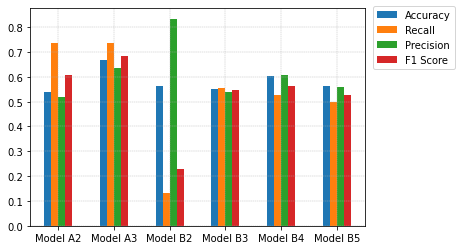

In [15]:
result.T.reset_index().rename(columns={'index':'Metric'}).plot(x='Metric',kind='bar',stacked=False,title='')


plt.xticks(rotation=0)
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.865))
plt.xlabel("")
plt.grid('on', linestyle='--',linewidth=0.4)
plt.show()

#### Se itera n veces el resultado anterior para estudiar el comportamiento de estas  métricas

In [4]:
# Parameters
T = 1000
N = 1000

In [7]:
results = []
for n in range(N):
    dfs = []
    for caex in data.CAEX.unique():
        indxs = data[data['CAEX']==caex].index
        select_ind = random.choice(list(indxs))
        dfs.append(pd.DataFrame(data.loc[select_ind,:]).T)
    dfs = pd.concat(dfs)
    dfs['survive'] = [1 if x>T else 0 for x in dfs.TBF]

    # CAEX  surviving 1000 hours and those that do not
    #==================================================
    CAEX_surv = dfs[dfs.survive==1].CAEX.to_list()
    CAEX_notsurv = dfs[dfs.survive==0].CAEX.to_list()
    caexs = dfs.reset_index(drop=True).CAEX
    #==================================================
    
    # Evaluating the models
    # =========================================================================================================================
    df_A2 = dfs[data_to_eval.columns].drop('TBF',axis=1).reset_index(drop=True)
    df_A3 = dfs[lasso_variables_wb].reset_index(drop=True)
    df_B3 = dfs[list(s[s.p<0.05].reset_index()['index'])]
    df_B4 = dfs[data_to_eval.drop(list(s[s.p<0.05].reset_index()['index']),axis=1).columns.to_list()]
    df_B5 = dfs[lasso_variables_cx]

    A2_CAEX_surv, A2_CAEX_notsurv, probs_A2 = evaluate_survivals(T=T,thetas=A2[0], beta=A2[1], df=df_A2,
                                                                 caex_list=caexs, model='weibull', fitted_model=A2)

    A3_CAEX_surv, A3_CAEX_notsurv, probs_A3 = evaluate_survivals(T=T,thetas=A3[0], beta=A3[1], df=df_A3,
                                                        caex_list=caexs, model='weibull', fitted_model=A2)

    B2_CAEX_surv, B2_CAEX_notsurv, probs_B2 = evaluate_survivals(T=T,thetas=pd.DataFrame(B2.params_).reset_index(),
                                                        beta=0, df=df_A2, caex_list=caexs, model='cox',fitted_model=B2)

    B3_CAEX_surv, B3_CAEX_notsurv, probs_B3  =  evaluate_survivals(T=T,thetas=pd.DataFrame(B3.params_).reset_index(),
                                                        beta=0, df=df_B3, caex_list=caexs,model='cox', fitted_model=B3)

    B4_CAEX_surv, B4_CAEX_notsurv, probs_B4 =  evaluate_survivals(T=T,thetas=pd.DataFrame(B4.params_).reset_index(),
                                                        beta=0, df=df_B4, caex_list=caexs,model='cox', fitted_model=B4)

    B5_CAEX_surv, B5_CAEX_notsurv, probs_B5 = evaluate_survivals(T=T,thetas=pd.DataFrame(B5.params_).reset_index(),
                                                        beta=0, df=df_B5, caex_list=caexs,model='cox', fitted_model=B5)
    
    CM_A2 = conf_matrix(CAEX_surv,CAEX_notsurv,A2_CAEX_surv,A2_CAEX_notsurv)
    CM_A3 = conf_matrix(CAEX_surv,CAEX_notsurv,A3_CAEX_surv,A3_CAEX_notsurv)
    CM_B2 = conf_matrix(CAEX_surv,CAEX_notsurv,B2_CAEX_surv,B2_CAEX_notsurv)
    CM_B3 = conf_matrix(CAEX_surv,CAEX_notsurv,B3_CAEX_surv,B3_CAEX_notsurv)
    CM_B4 = conf_matrix(CAEX_surv,CAEX_notsurv,B4_CAEX_surv,B4_CAEX_notsurv)
    CM_B5 = conf_matrix(CAEX_surv,CAEX_notsurv,B5_CAEX_surv,B5_CAEX_notsurv)

    metrics_A2 = conf_matrix_metrics(CM_A2)
    metrics_A3 = conf_matrix_metrics(CM_A3)
    metrics_B2 = conf_matrix_metrics(CM_B2)
    metrics_B3 = conf_matrix_metrics(CM_B3)
    metrics_B4 = conf_matrix_metrics(CM_B4)
    metrics_B5 = conf_matrix_metrics(CM_B5)

    result = pd.DataFrame({'Model A2':metrics_A2,'Model A3':metrics_A3,'Model B2':metrics_B2,'Model B3':metrics_B3,
                       'Model B4':metrics_B4,'Model B5':metrics_B5})
    result['Metric'] = ['Accuracy','Recall','Precision','F1 Score']
    result['N'] = [n]*len(result)
    results.append(result)
results = pd.concat(results)

In [11]:
results.head()

,Model A2,Model A3,Model B2,Model B3,Model B4,Model B5,Metric,N
0,0.474359,0.628205,0.538462,0.564103,0.589744,0.525641,Accuracy,0
1,0.685714,0.714286,0.0857143,0.628571,0.571429,0.428571,Recall,0
2,0.444444,0.568182,0.428571,0.511628,0.540541,0.46875,Precision,0
3,0.539326,0.632911,0.142857,0.564103,0.555556,0.447761,F1 Score,0
0,0.435897,0.487179,0.448718,0.448718,0.384615,0.410256,Accuracy,1


In [16]:
models = ['Model A2','Model A3','Model B2','Model B3','Model B4','Model B5']

auxs = []
for m in models:
    aux_model = results[[m,'Metric']].rename(columns={m:'value'})
    aux_model['MODEL'] = [m]*len(aux_model)
    auxs.append(aux_model)
auxs = pd.concat(auxs)

Text(0.5, 0, ' ')

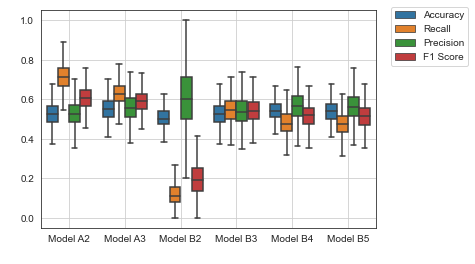

In [29]:
import seaborn as sns
sns.set_style('white')

pal = {"Accuracy": '#1f77b4', "Recall": "#ff7f0e", "Precision":"#2ca02c","F1 Score":'#d62728'}
sns.boxplot(x='MODEL', y='value', hue='Metric', data = auxs, palette=pal, fliersize=0)
#sns.stripplot(x='MODEL', y='value', hue='Metric', data = auxs, jitter=True, 
#              split=True, linewidth=0.5, palette=pal)

plt.grid('on')
plt.legend(loc='center left', bbox_to_anchor=(1.03, 0.88))
plt.ylabel(" ")
plt.xlabel(" ")

In [32]:
pd.pivot_table(auxs.groupby(['MODEL','Metric']).mean().reset_index(),
               values='value', index=['Metric'],columns=['MODEL'], aggfunc=np.sum)

MODEL,Model A2,Model A3,Model B2,Model B3,Model B4,Model B5
Metric,,,,,,
Accuracy,0.527179,0.554974,0.506872,0.526782,0.545244,0.540551
F1 Score,0.604976,0.589607,0.194316,0.539905,0.51761,0.512102
Precision,0.528611,0.557981,0.597783,0.537225,0.566407,0.560849
Recall,0.713275,0.6293,0.119559,0.546715,0.480182,0.474829


## Ahora se raliza el mismo procedimiento anterior para cada sistema en consideración

In [34]:
cols_to_drop = ['FALLA','FECHA','REP','CAEX','SISTEMA']
df = pd.read_excel('.\data.xlsx')
opt_wb_lambdas  = pd.read_excel('.\Optimals_AIC_CoxModels.xlsx')
opt_cox_lambdas = pd.read_excel('.\Optimals_AIC_WeibullAFTModels.xlsx')

In [94]:
T = 1000
N = 1000
metrics_by_models = []
for sis in df.SISTEMA.unique():
    
    data = df[df.SISTEMA ==sis] 
    data_to_eval = data.drop(cols_to_drop,axis=1).reset_index(drop=True)
    opt_wb_l  = opt_wb_lambdas[opt_wb_lambdas.SISTEMA==sis].reset_index(drop=True).loc[0,'$\lambda$']
    opt_cox_l = opt_cox_lambdas[opt_cox_lambdas.SISTEMA==sis].reset_index(drop=True).loc[0,'$\lambda$']
    residuals = []

    # Lasso Weibull reg.
    # =========================================================================================================================        
    w = WeibullAFTFitter(l1_ratio=1., penalizer=opt_wb_l).fit(data_to_eval, duration_col='TBF')
  
    res = pd.DataFrame(w.params_).reset_index()
    res_lambda = res[res.param=='lambda_'].rename(columns={0:'theta'})
    res_lambda = res_lambda[res_lambda.theta>1e-10]
    lasso_variables_wb = res_lambda.covariate.to_list()[:-1]
    # =========================================================================================================================

    # Proportional Hazard Test
    # =========================================================================================================================
    results = proportional_hazard_test(CoxPHFitter().fit(data_to_eval, duration_col='TBF'), data_to_eval, time_transform='km')
    s = results.summary
    # =========================================================================================================================

    # Lasso Cox Model
    # =========================================================================================================================
    cx = CoxPHFitter(l1_ratio=1., penalizer=opt_cox_l).fit(data_to_eval, duration_col='TBF')
    res = pd.DataFrame(cx.params_).reset_index()
    lasso_variables_cx = res[res.coef>1e-10].covariate.to_list()
    # =========================================================================================================================

    # Fitting the models A1-B5
    # =========================================================================================================================

    A1 = wb_AFT_reg(data=data[['TBF']],time_variable='TBF',residuals_list=residuals,ndecimals=3,print_results=False)
    A2 = wb_AFT_reg(data=data_to_eval,time_variable='TBF',residuals_list=residuals,ndecimals=3,print_results=False)
    A3 = wb_AFT_reg(data=data[['TBF']+lasso_variables_wb],time_variable='TBF',residuals_list=residuals,ndecimals=3,
                        print_results=False)

    B1 = CoxPHFitter().fit(data[['TBF']], duration_col='TBF')
    B2 = CoxPHFitter().fit(data_to_eval, duration_col='TBF')
    B3 = CoxPHFitter().fit(data[['TBF']+list(s[s.p<0.05].reset_index()['index'])], duration_col='TBF')
    B4 = CoxPHFitter().fit(data_to_eval.drop(list(s[s.p<0.05].reset_index()['index']),axis=1), duration_col='TBF')
    B5 = CoxPHFitter().fit(data[['TBF']+lasso_variables_cx], duration_col='TBF')

    # =========================================================================================================================

    
    results = []
    for n in range(N):
        dfs = []
        for caex in data.CAEX.unique():
            indxs = data[data['CAEX']==caex].index
            select_ind = random.choice(list(indxs))
            dfs.append(pd.DataFrame(data.loc[select_ind,:]).T)
        dfs = pd.concat(dfs)
        dfs['survive'] = [1 if x>T else 0 for x in dfs.TBF]

        # CAEX  surviving 1000 hours and those that do not
        #==================================================
        CAEX_surv = dfs[dfs.survive==1].CAEX.to_list()
        CAEX_notsurv = dfs[dfs.survive==0].CAEX.to_list()
        caexs = dfs.reset_index(drop=True).CAEX
        #==================================================

        # Evaluating the models
        # =========================================================================================================================
        df_A2 = dfs[data_to_eval.columns].drop('TBF',axis=1).reset_index(drop=True)
        df_A3 = dfs[lasso_variables_wb].reset_index(drop=True)
        df_B3 = dfs[list(s[s.p<0.05].reset_index()['index'])]
        df_B4 = dfs[data_to_eval.drop(list(s[s.p<0.05].reset_index()['index']),axis=1).columns.to_list()]
        df_B5 = dfs[lasso_variables_cx]

        A2_CAEX_surv, A2_CAEX_notsurv, probs_A2 = evaluate_survivals(T=T,thetas=A2[0], beta=A2[1], df=df_A2,
                                                                     caex_list=caexs, model='weibull', fitted_model=A2)

        A3_CAEX_surv, A3_CAEX_notsurv, probs_A3 = evaluate_survivals(T=T,thetas=A3[0], beta=A3[1], df=df_A3,
                                                            caex_list=caexs, model='weibull', fitted_model=A2)

        B2_CAEX_surv, B2_CAEX_notsurv, probs_B2 = evaluate_survivals(T=T,thetas=pd.DataFrame(B2.params_).reset_index(),
                                                            beta=0, df=df_A2, caex_list=caexs, model='cox',fitted_model=B2)

        B3_CAEX_surv, B3_CAEX_notsurv, probs_B3  =  evaluate_survivals(T=T,thetas=pd.DataFrame(B3.params_).reset_index(),
                                                            beta=0, df=df_B3, caex_list=caexs,model='cox', fitted_model=B3)

        B4_CAEX_surv, B4_CAEX_notsurv, probs_B4 =  evaluate_survivals(T=T,thetas=pd.DataFrame(B4.params_).reset_index(),
                                                            beta=0, df=df_B4, caex_list=caexs,model='cox', fitted_model=B4)

        B5_CAEX_surv, B5_CAEX_notsurv, probs_B5 = evaluate_survivals(T=T,thetas=pd.DataFrame(B5.params_).reset_index(),
                                                            beta=0, df=df_B5, caex_list=caexs,model='cox', fitted_model=B5)

        CM_A2 = conf_matrix(CAEX_surv,CAEX_notsurv,A2_CAEX_surv,A2_CAEX_notsurv)
        CM_A3 = conf_matrix(CAEX_surv,CAEX_notsurv,A3_CAEX_surv,A3_CAEX_notsurv)
        CM_B2 = conf_matrix(CAEX_surv,CAEX_notsurv,B2_CAEX_surv,B2_CAEX_notsurv)
        CM_B3 = conf_matrix(CAEX_surv,CAEX_notsurv,B3_CAEX_surv,B3_CAEX_notsurv)
        CM_B4 = conf_matrix(CAEX_surv,CAEX_notsurv,B4_CAEX_surv,B4_CAEX_notsurv)
        CM_B5 = conf_matrix(CAEX_surv,CAEX_notsurv,B5_CAEX_surv,B5_CAEX_notsurv)

        metrics_A2 = conf_matrix_metrics(CM_A2)
        metrics_A3 = conf_matrix_metrics(CM_A3)
        metrics_B2 = conf_matrix_metrics(CM_B2)
        metrics_B3 = conf_matrix_metrics(CM_B3)
        metrics_B4 = conf_matrix_metrics(CM_B4)
        metrics_B5 = conf_matrix_metrics(CM_B5)

        result = pd.DataFrame({'Model A2':metrics_A2,'Model A3':metrics_A3,'Model B2':metrics_B2,'Model B3':metrics_B3,
                           'Model B4':metrics_B4,'Model B5':metrics_B5})
        result['Metric'] = ['Accuracy','Recall','Precision','F1 Score']
        result['N'] = [n]*len(result)
        results.append(result)
    results = pd.concat(results)
    results['SISTEMA'] = [sis]*len(results)
    metrics_by_models.append(results)

In [ ]:
#pd.concat(metrics_by_models).to_excel('confusion_matrix_metrics_by_sistems.xlsx',index=False)

In [86]:
import seaborn as sns
sns.set_style('white')

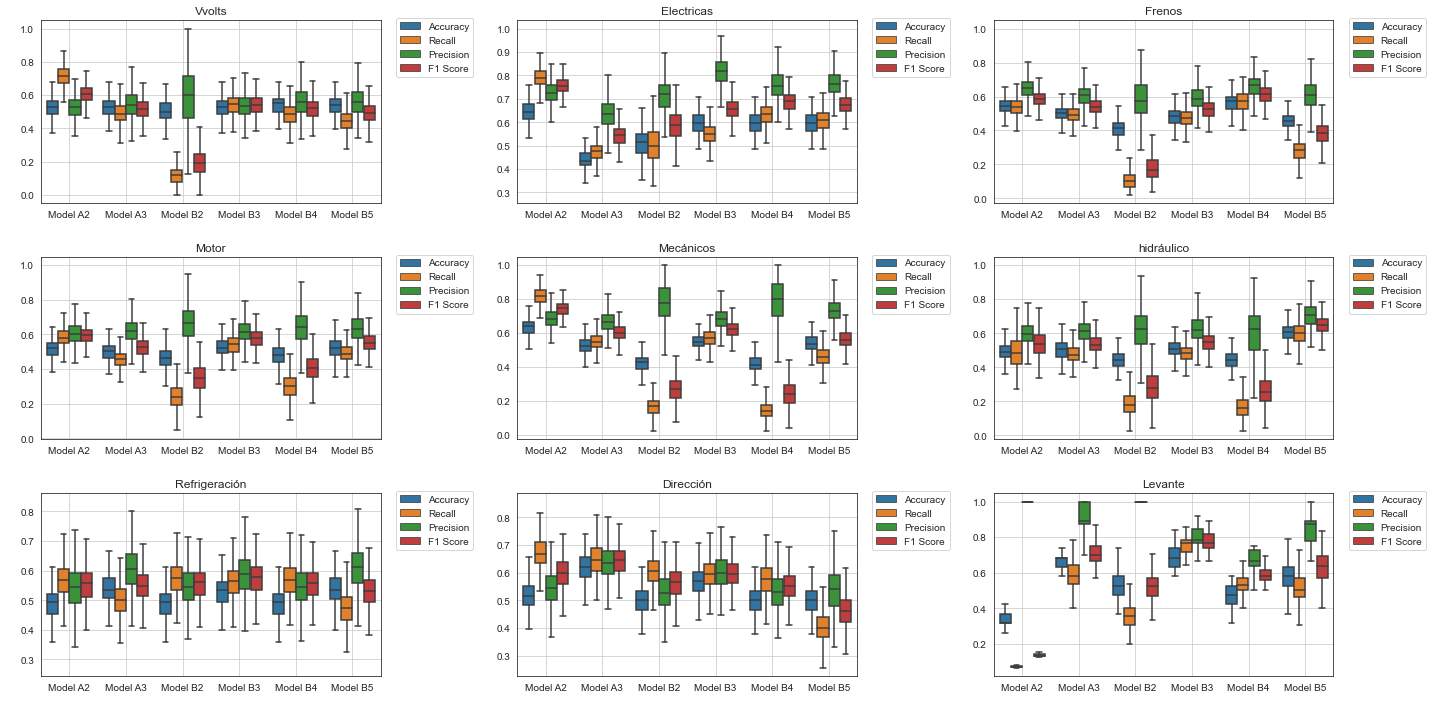

In [96]:
models = ['Model A2','Model A3','Model B2','Model B3','Model B4','Model B5']

fig = plt.figure(figsize=(20, 10))
i = 0
for s in metrics_by_models:
    auxs = []
    for m in models:
        aux_model = s[[m,'Metric']].rename(columns={m:'value'})
        aux_model['MODEL'] = [m]*len(aux_model)
        auxs.append(aux_model)
    auxs = pd.concat(auxs)

    plt.subplot(int('33'+str(i+1)))
    pal = {"Accuracy": '#1f77b4', "Recall": "#ff7f0e", "Precision":"#2ca02c","F1 Score":'#d62728'}
    sns.boxplot(x='MODEL', y='value', hue='Metric', data = auxs, palette=pal, fliersize=0)

    plt.title(s.reset_index(drop=True).loc[0,'SISTEMA'])
    plt.grid('on')
    plt.legend(loc='center left', bbox_to_anchor=(1.03, 0.85))
    plt.ylabel(" ")
    plt.xlabel(" ")
    i += 1
fig.tight_layout()    

In [97]:
summarys = []
for s in metrics_by_models:
    auxs = []
    for m in models:
        aux_model = s[[m,'Metric']].rename(columns={m:'value'})
        aux_model['MODEL'] = [m]*len(aux_model)
        auxs.append(aux_model)
    auxs = pd.concat(auxs)

    table = pd.pivot_table(auxs.groupby(['MODEL','Metric']).mean().reset_index(),
                   values='value', index=['Metric'],columns=['MODEL'], aggfunc=np.sum)
    table['SISTEMA'] = [s.reset_index(drop=True).loc[0,'SISTEMA']]*len(table)
    
    summarys.append(table)

In [100]:
summarys = pd.concat(summarys)#.to_excel('confusion_matrix_metrics_means_by_sistems.xlsx')

MODEL,Model A2,Model A3,Model B2,Model B3,Model B4,Model B5,SISTEMA
Metric,,,,,,,
Accuracy,0.52759,0.52959,0.506654,0.526756,0.543269,0.537628,Vvolts
F1 Score,0.604947,0.513599,0.193373,0.539107,0.515993,0.490695,Vvolts
Precision,0.52762,0.543344,0.587664,0.535467,0.560756,0.559004,Vvolts
Recall,0.715989,0.491802,0.119461,0.547448,0.481783,0.44112,Vvolts
Accuracy,0.642532,0.440645,0.510177,0.597903,0.599919,0.592742,Electricas
F1 Score,0.755397,0.542241,0.586764,0.65708,0.688526,0.675189,Electricas
Precision,0.725175,0.636279,0.714226,0.815588,0.756976,0.764852,Electricas
Recall,0.790924,0.473852,0.501112,0.551449,0.632978,0.60611,Electricas
Accuracy,0.542371,0.4951,0.409443,0.481957,0.564486,0.452957,Frenos


In [61]:
metrics = []
models  = []
sistems = []
for m in summarys.Metric.unique():
    s_pivot = summarys[summarys.Metric==m].T
    s_pivot.columns = list(s_pivot.loc['SISTEMA':].values[0])
    s_pivot = s_pivot.drop(['Metric','SISTEMA']).reset_index().rename(columns={'index':'Model'})
    for s in s_pivot.columns[1:]:
        vmax = s_pivot[[s]].max().to_list()[0]
        models.append(s_pivot[s_pivot[s]==vmax].Model.values[0])
        metrics.append(m)
        sistems.append(s)

In [66]:
pd.pivot_table(pd.DataFrame({'Metric':metrics,'SISTEM':sistems,'Model':models}), values='Model', index=['SISTEM'],
                    columns=['Metric'], aggfunc=lambda x:x)

Metric,Accuracy,F1 Score,Precision,Recall
SISTEM,,,,
Dirección,Model A3,Model A3,Model A3,Model A2
Electricas,Model A2,Model A2,Model B3,Model A2
Frenos,Model B4,Model B4,Model B4,Model B4
Levante,Model B3,Model B3,Model A2,Model B3
Mecánicos,Model A2,Model A2,Model B4,Model A2
Motor,Model B3,Model A2,Model B2,Model A2
Refrigeración,Model A3,Model B3,Model B5,Model B2
Vvolts,Model B4,Model A2,Model B2,Model A2
hidráulico,Model B5,Model B5,Model B5,Model B5


In [71]:
pd.pivot_table(pd.DataFrame({'Metric':metrics,'SISTEM':sistems,'Model':models}), values='SISTEM', index=['Model'],
                    columns=['Metric'], aggfunc='count').fillna(0)

Metric,Accuracy,F1 Score,Precision,Recall
Model,,,,
Model A2,2,4,1,5
Model A3,2,1,1,0
Model B2,0,0,2,1
Model B3,2,2,1,1
Model B4,2,1,2,1
Model B5,1,1,2,1
